#  Complex step approximation and Automatic Differentiation
### Francesco Pasqualini
## Complex step approximation

$$  \begin{align}   
{f(x + ih) = f (x) + ih f^\prime(x) - {{h^2 } \over 2!} f^{\prime\prime}(x) + \mathcal{O}(h^{3})\tag{1}  }
\end{align} $$

$$  \begin{align}   
{ f(x) = Re f(x + ih) + \mathcal{O}(h^{2})  } \tag{2}  
\end{align} $$

$$  \begin{align}   
{ f^\prime(x) = Im {f(x + ih)\over h} + \mathcal{O}(h^{2})  } \tag{3}  
\end{align} $$

$$  \begin{align}   
{ f^\prime(x) = Im {f(x + ih)\over h} -  {{h^2 } \over 2!} f^{\prime\prime}(x) + \mathcal{O}(h^{3})  } \tag{4}  
\end{align} $$


>The usual way to approximate derivatives is with finite differences, for example by the forward difference approximation
This approximation has error $\mathcal{O}(h)$ so it is less accurate than the complex step approximation for a given h, but more importantly it is prone to numerical cancellation. For small $h$, $f(x+h)$ and $f(x)$ agree to many significant digits and so in floating-point arithmetic the difference approximation suffers a loss of significant digits. Consequently, as $h$ decreases the error in the computed approximation eventually starts to increase. As numerical analysis textbooks explain, the optimal choice of h that balances truncation error and rounding errors is approximately $h_{opt}$ 

$$  \begin{align}   
{ f^\prime(x) = {{f(x + ih)-f(x)}\over h} + \mathcal{O}(h)  }  \tag{5}
\end{align} $$

$$  
\begin{align}   
{ h_{opt} = 2 { \bigg\vert {u f(x) \over f^{\prime\prime}(x)} \bigg\vert }}^2 \tag{6}
\end{align} $$
>where $u$ is the unit roundoff. The optimal error is therefore of order $u^{1/2}$.

When using the complex-step derivative approximation, in order to effectively
eliminate truncation errors, it is typical to use a step that is many orders of
magnitude smaller than the real part of the calculation. When the truncation errors are eliminated, the higher-order terms of the derivative approximation (4)
are so small that they vanish when added to other terms using finite-precision
arithmetic. We obtain:

$$  \begin{align}   
{f(x + ih) \equiv f (x) + ih f^\prime(x) \tag{7}  }
\end{align} $$

where the imaginary part is exactly the derivative of $f$ times $h$.
The end result
is a sensitivity calculation method that is equivalent to the forward mode of
algorithmic differentiation (also known as automatic differentiation or AD), as observed by Griewank [2000, chap. 10, p. 227].


## Automatic differentiation

Just as the complex step approximation is based on complex numbers, so the automatic differentiation is based on double numbers.

### Dual numbers
Dual numbers are a hypercomplex number system first introduced in the 19th century. They are expressions of the form $a + bε$, where a and b are real numbers, and ε is a symbol taken to satisfy ${\displaystyle \varepsilon ^{2}=0}$.

$${\displaystyle f(a+b\varepsilon )=\sum _{n=0}^{\infty }{\frac {f^{(n)}(a)b^{n}\varepsilon ^{n}}{n!}}=f(a)+bf'(a)\varepsilon }$$

So using Taylor seires we can extend any (analytic) real function to the dual numbers.
The interesting thing is that by computing compositions of these extended functions over the dual numbers and examining the coefficient of ε in the result we find we have automatically computed the derivative of the composition.

### Automatc differentiation

>In mathematics and computer algebra, automatic differentiation
(AD) is a set of techniques to evaluate the derivative of a function specified
by a computer program. AD exploits the fact that every computer program, no
matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.), elementary functions
(exp, log, sin, cos, etc.) and control flow statements. AD takes source code of a
function as input and produces source code of the derived function. By applying
the chain rule repeatedly to these operations, derivatives of arbitrary order can
be computed automatically, accurately to working precision, and using at most
a small constant factor more arithmetic operations than the original program.

### Foating point error estimation

$$ A_f = \vert f(x + h) - f(x) \vert  $$
to the first odrer become
$$ A_f \equiv \vert h f^{\prime}(x) \vert  $$
$$ h = \vert x \vert \epsilon{_M}  $$
then the absolute error is
$$ A_f \equiv  f^{\prime}(x) \cdot \vert x \vert \cdot \epsilon{_M}  $$

A more general formula is
$$ A_f \equiv \sum _{i=0}^{n} \bigg\vert \frac{\partial f}{\partial x_i} \bigg\vert \cdot \vert x_{i} \vert  \cdot \epsilon{_M} + E_{L} $$

Where:
- $A_{f}$ is the absolute error in a function f
- $x_{i}$ all input and intermediate variables
- $E_{L}$ the error due to the Taylor serie linearization 
- $\epsilon_{M}$ is the machine epsilon


## References
[What Is the Complex Step Approximation? - Nick Higham](https://nhigham.com/2020/10/06/what-is-the-complex-step-approximation/)

[The Complex-Step Derivative Approximation - JOAQUIM R. R. A. MARTINS 2003](https://www.researchgate.net/publication/222112601_The_Complex-Step_Derivative_Approximation)

[The complex-step derivative approximation - Joaquim J Martins, Peter Sturdza, Juan J Alonso 2017](https://hal.archives-ouvertes.fr/hal-01483287/document)

[Automatic Differentiation in ROOT - Vassil Vassilev, Aleksandr Efremov, Oksana Shadura 2019](https://www.epj-conferences.org/articles/epjconf/pdf/2020/21/epjconf_chep2020_02015.pdf)

[Estimating Floating-Point Errors Using Automatic Differentiation - - Vassil Vassilev and Garima Singh 2002](https://www.youtube.com/watch?v=pndnawFPKHA)


In [1]:
#include <string>
#include <fstream>
#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"
#pragma cling add_include_path("/srv/conda/envs/notebook/include/python3.7m")
#pragma cling add_include_path("/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/include/")
#pragma cling add_library_path("/srv/conda/envs/notebook/lib/")
#pragma cling load("python3.7m")
#include "clad/Differentiator/Differentiator.h"
#include <iostream>
#include "../../matplotlibcpp.h"
#include <iostream>
#include <complex>
#include <cmath>


namespace plt = matplotlibcpp;
namespace im
{
    struct image
    {   
        inline image(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);   
            m_buffer << fin.rdbuf();
        }        
        std::stringstream m_buffer;
    };
    nl::json mime_bundle_repr(const image& i)
    {
        auto bundle = nl::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }
}

using namespace std;
using namespace std::complex_literals;

typedef complex<long double> dcomp;


long double function_fn(long double x) {
  return exp(x)/(pow((cos(x)),3) + pow(sin(x),3));
}

dcomp function_cfn(dcomp x) {
  return exp(x)/(pow((cos(x)),3) + pow(sin(x),3));
}


long double derivative_fn(long double x) {
  return (exp(x)*(cos(3*x) + sin(3*x)/2 + (3*sin(x))/2)) / 
            pow(pow(cos(x),3) + pow(sin(x),3),2);
}

long double derivative_finite_diff_approx(long double x,long double h) {
  return (function_fn(x+h) - function_fn(x))/h;
}


long double derivative_complex_step_approx(long double x,long  double h) {
  return imag(function_cfn(dcomp(x,h)))/h;
}


long double derivative_ad_reverse(long double x) {
    long double dy = 0;
    auto f_grad = clad::gradient(function_fn, "x");
    f_grad.execute(x, &dy);
    return dy;
}


    
auto fn_dx = clad::differentiate(function_fn, "x");


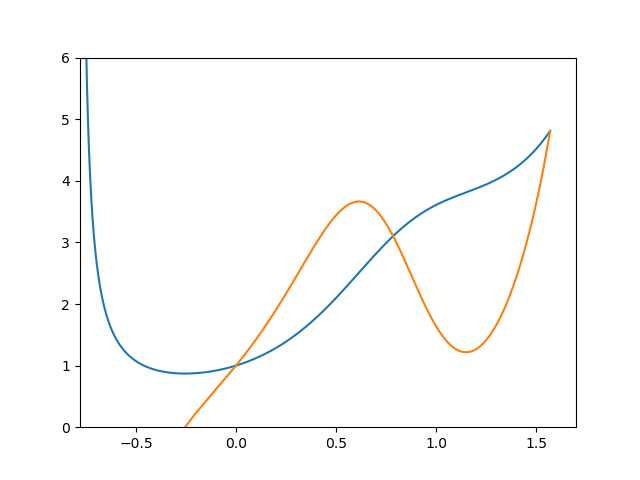

In [2]:

    std::vector<float> x;
    std::vector<float> y;
    std::vector<float> y1;
    long double pi, a, b;
    int N = 1000;
    pi =  2 * asin(1);
    a = - pi/4;
    b = pi / 2;
    for (float j = a; j <= b; j += (b-a)/N) {
        x.push_back(j);
        y.push_back(function_fn(j));
        y1.push_back(fn_dx.execute(j));
    }

plt::plot(x, y);
plt::plot(x, y1);
plt::ylim(0, 6);
plt::xlim(-0.78, 1.7);
plt::save("../../test/test3.png");
auto img = im::image("../../test/test3.png");
img

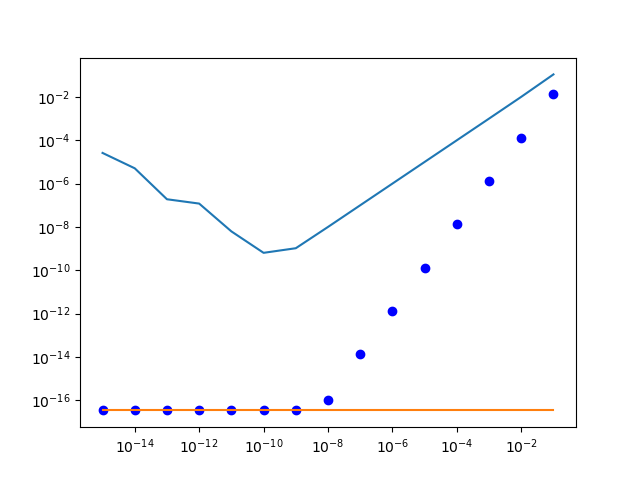

In [3]:
std::vector<long double> logspace;
std::vector<long double> error_ff;
std::vector<long double> error_complex_step;
std::vector<long double> error_ad;
long double point_x  =  pi/4;

for (int i = 15; i >= 1; i -= 1) {
    logspace.push_back(pow(10,-i));
}

for(long double h : logspace) {
   error_ff.push_back(abs(derivative_finite_diff_approx(point_x, h) - derivative_fn(point_x))/abs(derivative_fn(point_x)));
   error_complex_step.push_back(abs(derivative_complex_step_approx(point_x, h) - derivative_fn(point_x))/abs(derivative_fn(point_x)));
   //error_ad.push_back(abs(fn_dx.execute(point_x) - derivative_fn(point_x))/abs(derivative_fn(point_x)));   
   error_ad.push_back(abs(derivative_ad_reverse(point_x) - derivative_fn(point_x))/abs(derivative_fn(point_x)));   
}

plt::figure();
plt::loglog(logspace, error_ff);
plt::loglog(logspace, error_complex_step, "bo");
plt::loglog(logspace, error_ad);
plt::save("../../test/test_err.png");
auto img2 = im::image("../../test/test_err.png");
img2

In [6]:
auto f_grad = clad::gradient(function_fn, "x");
f_grad.dump();

The code is: void function_fn_grad(long double x, clad::array_ref<long double> _d_x) {
    long double _t2;
    long double _t3;
    long double _t4;
    long double _t5;
    long double _t6;
    long double _t7;
    long double _t8;
    _t3 = x;
    _t4 = exp(_t3);
    _t5 = x;
    _t6 = cos(_t5);
    _t7 = x;
    _t8 = sin(_t7);
    _t2 = (pow(_t6, 3) + pow(_t8, 3));
    long double function_fn_return = _t4 / _t2;
    goto _label0;
  _label0:
    {
        long double _r0 = 1 / _t2;
        long double _r1 = _r0 * custom_derivatives::exp_darg0(_t3);
        * _d_x += _r1;
        long double _r2 = 1 * -_t4 / (_t2 * _t2);
        typename __gnu_cxx::__promote_2<long double, int>::__type _grad0 = 0.L;
        typename __gnu_cxx::__promote_2<long double, int>::__type _grad1 = 0.L;
        custom_derivatives::pow_grad(_t6, 3, &_grad0, &_grad1);
        typename __gnu_cxx::__promote_2<long double, int>::__type _r3 = _r2 * _grad0;
        long double _r4 = _r3 * custom_derivatives::cos_dar

#### Using Automatic Differentiation

```cpp

auto df = clad::estimate_error(derivative_fn);

// Print the generated code to standard output.
df.dump();

long double pi =  2 * asin(1);
long double d_x, final_error = 0;
long double point_x =  pi/4;


// compute the error in point_x
df.execute(point_x, &d_x, final_error);
printf("final_error='%f'\n", final_error);


void derivative_fn_grad(double x, clad::array_ref<double> _d_x, double &_final_error) {
    double _t0;
    double _t1;
    double _t2;
    double _ret_value0 = 0;
    _t1 = 3 * x;
    _t2 = 3 * x;
    _t0 = (std::cos(_t1) + std::sin(_t2) / 2 + (3 * std::sin(x)) / 2);
    double derivative_fn_return = (std::exp(x) * _t0) / std::pow(std::pow(std::cos(x), 3) + std::pow(std::sin(x), 3), 2);
    _ret_value0 = derivative_fn_return;
    goto _label0;
  _label0:
    {
        typename __gnu_cxx::__promote_2<double, int>::__type _r0 = std::pow(std::pow(std::cos(x), 3) + std::pow(std::sin(x), 3), 2);
        double _r1 = 1 / _r0;
        double _r2 = _r1 * _t0;
        double _r3 = _r2 * clad::custom_derivatives::exp_pushforward(x, 1.).pushforward;
        * _d_x += _r3;
        double _r4 = std::exp(x) * _r1;
        double _r5 = _r4 * clad::custom_derivatives::cos_pushforward(_t1, 1.).pushforward;
        double _r6 = _r5 * x;
        double _r7 = _r4 / 2;
        double _r8 = _r7 * clad::custom_derivatives::sin_pushforward(_t2, 1.).pushforward;
        double _r9 = _r8 * x;
        double _r10 = _r4 / 2;
        double _r11 = _r10 * std::sin(x);
    }
    double _delta_x = 0;
    _delta_x += std::abs(* _d_x * x * 1.1920928955078125E-7);
    _final_error += _delta_x + std::abs(1. * _ret_value0 * 1.1920928955078125E-7);
}

final_error='0.000001'
```